## Parallelization
1. Task /nodes dont depend on each other. Each node starts with same input and produce their own output, later all output combine to form a desire output.
2. means all nodes run parallel. 

In [13]:
#Customer Support Message Analyzer

#Goal
# Receives one customer support message, and the system analyzes it in parallel to help a support agent respond faster.

In [14]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq


load_dotenv()
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

llm=ChatGroq(model="llama-3.1-8b-instant")

In [25]:
from typing_extensions import TypedDict


class State(TypedDict):
    customer_message:str
    intent:str
    emotion:str
    priority:str
    response_suggestion:str
    
    
# Parallel nodes
def detect_intent(state:State):
    msg=llm.invoke(f"Identify the customer intention of this message like its a complain/inquiry/refund/cancellation: {state['customer_message']}")    
    return{"intent":msg.content}


def detect_emotion(state:State):
    msg=llm.invoke(f"Identify the customer emotion through this message: {state['customer_message']}")
    return{"emotion":msg.content}

def detect_priority(state:State):
    msg=llm.invoke(f"Identify the customer priority(low, medium, high) for this message: {state['customer_message']}")
    return{"priority":msg.content}


#Agregater node (Combine all of them)

def combine(state: State):
    msg = llm.invoke(
        f"""
        Based on:
        Intent: {state["intent"]}
        Emotion: {state["emotion"]}
        Priority: {state["priority"]}

        Suggest a suitable support response.
        """
    )
    return {"response_suggestion": msg.content}

        

In [26]:
from langgraph.graph import START,StateGraph,END


graph=StateGraph(State)

graph.add_node("Intent", detect_intent)
graph.add_node("Emotion", detect_emotion)
graph.add_node("Priority", detect_priority)
graph.add_node("Response", combine)


graph.add_edge(START,"Intent")
graph.add_edge(START,"Emotion")
graph.add_edge(START,"Priority")

graph.add_edge("Intent","Response")
graph.add_edge("Emotion","Response")
graph.add_edge("Priority","Response")
graph.add_edge("Response",END)


compiled_graph=graph.compile()

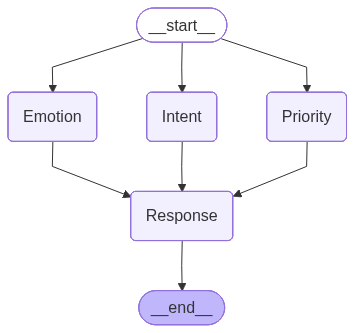

In [ ]:
from IPython.display import Image,display

graph_image=compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [27]:
result=compiled_graph.invoke(
    {
        "customer_message":"My payment was deducted twice and no one is replying. This is very frustrating."
    }
)

print(result["response_suggestion"])


Based on the customer's message and the identified intent, emotion, and priority, a suitable support response could be:

"Dear valued customer,

We apologize for the frustrating experience you've had with your payment being deducted twice. We understand that this is not only inconvenient but also a financial loss for you. We take situations like this seriously and want to make it right.

Our records indicate that you have reached out to us previously, and we appreciate your patience and persistence in bringing this issue to our attention.

To resolve this matter, we will immediately initiate a refund for the incorrect transaction. You will receive a notification once the refund has been processed.

We value your business and appreciate the opportunity to serve you better. We will also look into the issue with our customer service response time to ensure that our customers receive the attention they deserve.

If you have any further questions or concerns, please don't hesitate to reach 